In [58]:
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import matplotlib.pyplot as plt
import pandas as pd
import os
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
CSV_PATH = 'data.csv'

**REVISED DATASETCLASS**

In [26]:
class IMD2020Dataset(torch.utils.data.Dataset):
    def __init__(self, csv_path):
        self.csv = pd.read_csv(csv_path)

        self.transforms_fake = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((224,224)),
            torchvision.transforms.Normalize(mean= 0, std = 1, inplace= True)
        ])

        self.transforms_mask = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((224,224))
        ])
    
    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        row = self.csv.iloc[idx]
        fake, mask = row['fakes'], row['masks']

        fake = cv.imread(fake)
        mask = cv.imread(mask)

        mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)

        fake_t = self.transforms_fake(fake)
        mask_t = self.transforms_mask(mask)
        
        return fake_t, mask_t

In [27]:
ds = IMD2020Dataset(CSV_PATH)

In [28]:
len(ds)

2010

In [29]:
ds

In [ ]:
n1 = 0
n2 = 0

c:\Users\Hp\Desktop\Phosphene.ai\BaseLineU-Net\newenv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 224, 224]) torch.Size([1, 224, 224])
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


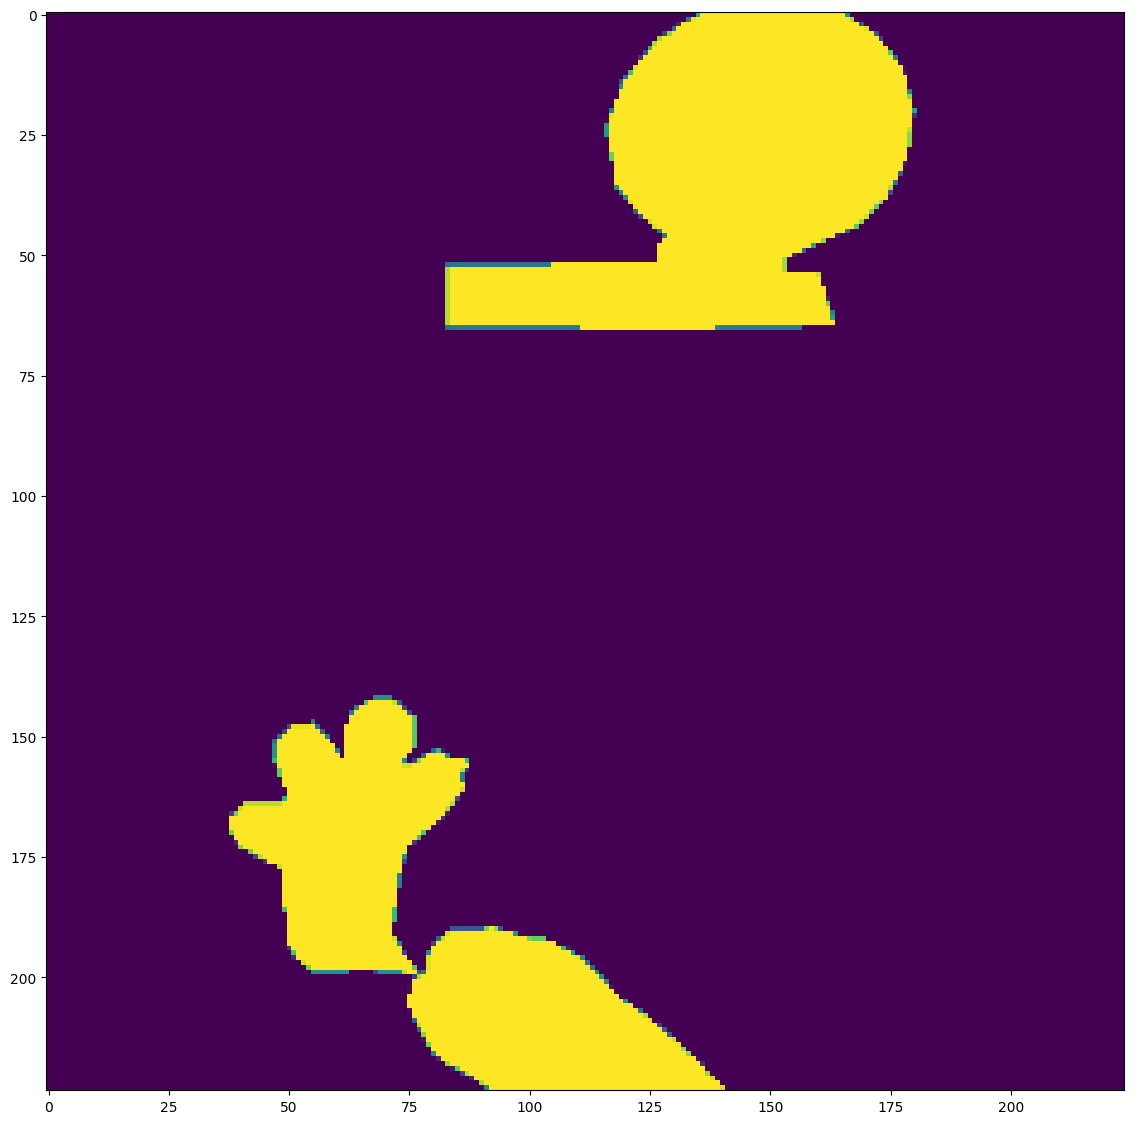

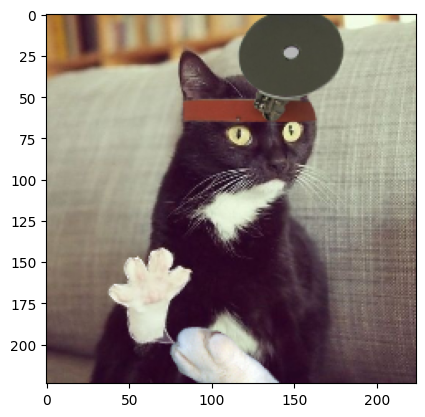

In [33]:
for batch in ds:
    print(batch[0].size(), batch[1].size())
    plt.figure(figsize=(14,14))
    plt.imshow(batch[1].numpy().transpose((1,2,0)))
    print(batch[1].numpy())
    plt.show()
    plt.imshow(cv.cvtColor(batch[0].numpy().transpose((1,2,0)),cv.COLOR_RGB2BGR))
    plt.show()
    n1 = batch[1].numpy()
    n2 = batch[0].numpy()
    break

In [35]:
im = n2*n1

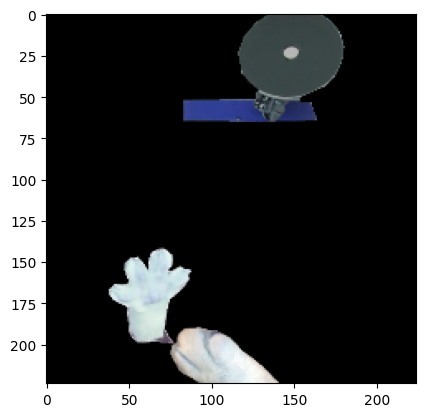

In [36]:
plt.imshow(im.transpose((1,2,0)))

In [39]:
torch.Tensor(n1).dim()

3

In [40]:
torch.Tensor(n2).dim()

3

In [41]:
n1.shape

(1, 224, 224)

In [42]:
n2.shape

(3, 224, 224)

**TRAIN SPLIT DATA LOADER CHECK**

In [59]:
train_split = int(len(ds) * 0.9)
val_split = len(ds) - train_split

train_set, val_set = random_split(ds,[train_split,val_split])
batch_size = 32

In [60]:
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_set, batch_size = batch_size,shuffle=False)

In [62]:
for i in train_loader:
    print(i[0],i[1])
    break

c:\Users\Hp\Desktop\Phosphene.ai\BaseLineU-Net\newenv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[[[5.4186e-01, 6.9646e-01, 6.0272e-01,  ..., 9.5728e-01,
           9.7707e-01, 9.7255e-01],
          [5.3286e-01, 6.5855e-01, 6.8600e-01,  ..., 9.5856e-01,
           9.8824e-01, 9.7826e-01],
          [5.2369e-01, 6.2452e-01, 7.2916e-01,  ..., 9.7780e-01,
           9.8725e-01, 9.7742e-01],
          ...,
          [5.4660e-01, 4.5266e-01, 5.5841e-01,  ..., 5.3015e-01,
           5.6713e-01, 7.1099e-01],
          [5.1065e-01, 6.5750e-01, 8.2467e-01,  ..., 5.1649e-01,
           6.0432e-01, 7.0707e-01],
          [5.2578e-01, 4.8181e-01, 4.6417e-01,  ..., 4.7122e-01,
           6.1198e-01, 6.8235e-01]],

         [[6.3461e-01, 7.9467e-01, 6.8462e-01,  ..., 9.2983e-01,
           9.3393e-01, 9.2549e-01],
          [6.3334e-01, 7.6075e-01, 7.5747e-01,  ..., 9.2100e-01,
           9.3333e-01, 9.3120e-01],
          [6.3562e-01, 7.2566e-01, 7.9114e-01,  ..., 9.3263e-01,
           9.3235e-01, 9.3036e-01],
          ...,
          [5.6273e-01, 4.7817e-01, 5.5802e-01,  ..., 6.4982

**VALIDATE DICE LOSS**

In [43]:
import torch
from torch import Tensor

In [44]:
def Dice_Loss(input : Tensor, target : Tensor, reduce_batch_first : bool = False, epsilon : float = 1e-6):

    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1,-2) if input.dim() == 2 or not reduce_batch_first else (-1,-2,-3)

    intersection = 2 * (input * target).sum(dim=sum_dim)
    setssum = input.sum(dim=sum_dim) + target.sum(dim = sum_dim)

    setssum = torch.where(setssum == 0, intersection, setssum)

    dice = (intersection + epsilon) / (setssum + epsilon)
    return dice.mean()



In [45]:
def dice_loss(input: Tensor, target: Tensor):
    return 1 - Dice_Loss(input, target, reduce_batch_first=True)

In [46]:
pred = torch.rand(1 ,244, 244)
true = torch.randint(0,2, (1,244,244), dtype = torch.float32)

In [55]:
pred

tensor([[[0.2074, 0.2170, 0.6743,  ..., 0.8848, 0.3967, 0.1290],
         [0.9359, 0.6512, 0.6258,  ..., 0.4054, 0.6451, 0.2763],
         [0.9218, 0.5644, 0.9920,  ..., 0.0546, 0.4819, 0.2013],
         ...,
         [0.1711, 0.2881, 0.7050,  ..., 0.8908, 0.1468, 0.9536],
         [0.9019, 0.0517, 0.9191,  ..., 0.5598, 0.3236, 0.1020],
         [0.7798, 0.6531, 0.5026,  ..., 0.9249, 0.6401, 0.7896]]])

In [56]:
true

tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 1., 0.],
         ...,
         [0., 1., 0.,  ..., 1., 0., 0.],
         [1., 1., 0.,  ..., 1., 1., 1.],
         [0., 1., 0.,  ..., 0., 1., 0.]]])

In [49]:
Dice_Loss(pred, true)

tensor(0.4993)

In [54]:
dice_loss(pred, true).numpy().astype(float)

array(0.50068843)